# Import Modules

In [1]:
import string
import numpy as np
from PIL import Image
import os
from pickle import dump, load
from keras.applications.xception import Xception, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical, plot_model
from keras.layers.merge import add
from keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add
# small library for seeing the progress of loops.
from tqdm.notebook import tqdm
tqdm.pandas()
import matplotlib.pyplot as plt
%matplotlib inline

# Path Directory

In [7]:
dataset_text = "data\\text"
dataset_images = "data\\Images"
save_data = "data\\output"

# Performing data cleaning

In [3]:
# Loading a text file into memory
def load_doc(filename):
    # Opening the file as read only
    file = open(filename, 'r')
    text = file.read()
    file.close()
    return text

# get all imgs with their captions
def all_img_captions(filename):
    file = load_doc(filename)
    descriptions = {}
    for line in file.split('\n'):
        tokens = line.split()
        if len(line) > 2:
            image_id = tokens[0].split(',')[0]
            image_desc = ' '.join(tokens[1:])
        if image_id not in descriptions:
              descriptions[image_id] = []
        descriptions[image_id].append(image_desc)
    return descriptions

#Data cleaning- lower casing, removing puntuations and words containing numbers
def cleaning_text(captions):
    table = str.maketrans('','',string.punctuation)
    for img,caps in captions.items():
        for i,img_caption in enumerate(caps):
            img_caption.replace("-"," ")
            desc = img_caption.split()
            #converts to lowercase
            desc = [word.lower() for word in desc]
            #remove punctuation from each token
            desc = [word.translate(table) for word in desc]
            #remove hanging 's and a 
            desc = [word for word in desc if(len(word)>1)]
            #remove tokens with numbers in them
            desc = [word for word in desc if(word.isalpha())]
            #convert back to string
            img_caption = ' '.join(desc)
            captions[img][i]= img_caption
    return captions

def text_vocabulary(descriptions):
    # build vocabulary of all unique words
    vocab = set()
    for key in descriptions.keys():
        [vocab.update(d.split()) for d in descriptions[key]]
    #sort vocabulary
    vocab=list(vocab)
    vocab.sort()
    return vocab

#All descriptions in one file 
def save_descriptions(descriptions, filename):
    lines = list()
    for key, desc_list in descriptions.items():
        for desc in desc_list:
            lines.append(key + '\t' + desc )
    data = "\n".join(lines)
    file = open(filename,"w")
    file.write(data)
    file.close()

In [4]:
#we prepare our text data
filename = dataset_text + "\\" + "captions.txt"
#loading the file that contains all data
#mapping them into descriptions dictionary img to 5 captions
descriptions = all_img_captions(filename)
print("Length of descriptions =" ,len(descriptions))
#print(descriptions)

Length of descriptions = 8101


# Split the data into training and testing

In [5]:
#Split data into Train(80%) and Test(20%)
l = len(descriptions)*0.8
train = dict(list(descriptions.items())[0: int(l)])
test = dict(list(descriptions.items())[int(l):])
print("Length of Train descriptions =" ,len(train.keys()))
print("Length of Test descriptions =" ,len(test.keys()))

Length of Train descriptions = 6480
Length of Test descriptions = 1621


In [8]:
#saving each description to file before cleaning 
save_descriptions(descriptions,(os.path.join(save_data, "descriptions.txt")))
save_descriptions(test,(os.path.join(save_data,"test_descriptions.txt")))

In [9]:
#cleaning the descriptions
all_clean_descriptions = cleaning_text(descriptions)
clean_train_descriptions = cleaning_text(train)

In [10]:
#building vocabulary 
vocabulary = text_vocabulary(clean_train_descriptions)
print("Length of vocabulary = ", len(vocabulary))

Length of vocabulary =  7911


In [11]:
#saving each description to file before cleaning 
save_descriptions(clean_train_descriptions,(os.path.join(save_data,"train_descriptions.txt")))

# Visualize

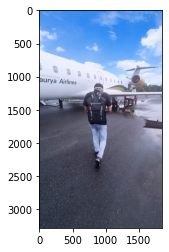

['boy walking towards the aeroplane',
 'aeroplane ready for the takeoff',
 'boy carrying bag walking towards aeroplane',
 'aeroplane is parked in the airport',
 'clear blue sky seen from the airport']

In [16]:
#Let’s visualize an example image and its captions
pic = '\\Bibek2.jpg'
x=plt.imread(dataset_images+pic)
plt.imshow(x)
plt.show()
descriptions['Bibek2.jpg']

# Extract Image Features

In [26]:
# #Extracting the feature vector from all images 
# def extract_features(directory):
#         model = Xception( include_top=False, pooling='avg' )
#         features = {}
#         for img in tqdm(os.listdir(directory)):
#             filename = directory + "/" + img
#             image = Image.open(filename)
#             image = image.resize((299,299))
#             image = np.expand_dims(image, axis=0)
#             image = image/255
#             feature = model.predict(image)
#             features[img] = feature
#         return features
# #2048 feature vector
# features = extract_features(dataset_images)
# #store features
# dump(features, open(os.path.join(save_data,"features.p"), "wb"))

In [28]:
#load features
features = load(open(os.path.join(save_data,"features.p"),"rb"))

# Loading dataset for Training the model

In [29]:
def load_photos(filename):
    file = load_doc(filename)
    photos = file.split('\n')[:-1]
    return photos
def load_clean_descriptions(filename, photos): 
    #loading clean_descriptions
    file = load_doc(filename)
    descriptions = {}
    for line in file.split('\n'):
        words = line.split()
        if len(words)<1 :
            continue
        image, image_caption = words[0], words[1:]
        if image in photos:
            if image not in descriptions:
                descriptions[image] = []
            desc = '<start> ' + " ".join(image_caption) + ' <end>'
            descriptions[image].append(desc)
    return descriptions
def load_features(photos):
    #loading all features
    all_features = load(open(os.path.join(save_data,"features.p"),"rb"))
    #selecting only needed features
    features = {k:all_features[k] for k in photos}
    return features

In [30]:
filename = dataset_text + "\\" + "train_imgs.txt"
train_imgs = load_photos(filename)
train_descriptions = load_clean_descriptions((os.path.join(save_data,"train_descriptions.txt")), train_imgs)
train_features = load_features(train_imgs)

# Tokenizing the vocabulary

In [31]:
#converting dictionary to clean list of descriptions
def dict_to_list(train):
    all_desc = []
    for key in train.keys():
        [all_desc.append(d) for d in train[key]]
    return all_desc
#creating tokenizer class 
#this will vectorise text corpus
#each integer will represent token in dictionary
from keras.preprocessing.text import Tokenizer
def create_tokenizer(train):
    desc_list = dict_to_list(train)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(desc_list)
    return tokenizer
# give each word an index, and store that into tokenizer.p pickle file
tokenizer = create_tokenizer(train_descriptions)
dump(tokenizer, open(os.path.join(save_data,"tokenizer.p"),"wb"))
vocab_size = len(tokenizer.word_index)
vocab_size

7909

In [32]:
# calculate maximum length of descriptions
def max_length(train):
    desc_list = dict_to_list(train)
    return max(len(d.split()) for d in desc_list)
    
max_length = max_length(train)
max_length

31

# Create Data generator

In [33]:
#create input-output sequence pairs from the image description.
#data generator, used by model.fit_generator()
def data_generator(train, features, tokenizer, max_length):
    while 1:
        for key, train_list in train.items():
            #retrieve photo features
            feature = features[key][0]
            input_image, input_sequence, output_word = create_sequences(tokenizer, max_length, train_list, feature)
        
            yield [[input_image, input_sequence], output_word]
def create_sequences(tokenizer, max_length, desc_list, feature):
    X1, X2, y = list(), list(), list()
    # walk through each description for the image
    for desc in desc_list:
        # encode the sequence
        seq = tokenizer.texts_to_sequences([desc])[0]
        # split one sequence into multiple X,y pairs
        for i in range(1, len(seq)):
            # split into input and output pair
            in_seq, out_seq = seq[:i], seq[i]
            # pad input sequence
            in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
            # encode output sequence
            out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
            # store
            X1.append(feature)
            X2.append(in_seq)
            y.append(out_seq)
    return np.array(X1), np.array(X2), np.array(y)
#You can check the shape of the input and output for your model
[a,b],c = next(data_generator(train_descriptions, features, tokenizer, max_length))
a.shape, b.shape, c.shape

((33, 2048), (33, 31), (33, 7909))

# Create Model

In [34]:
from tensorflow.keras.utils import plot_model
# define the captioning model
def define_model(vocab_size, max_length):
    # features from the CNN model squeezed from 2048 to 256 nodes
    inputs1 = Input(shape=(2048,))
    fe1 = Dropout(0.4)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)
    # LSTM sequence model
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.4)(se1)
    se3 = LSTM(256)(se2)
    # Merging both models
    decoder1 = add([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)
    # tie it together [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])
    # summarize model
    print(model.summary())
    return model

In [35]:
model = define_model(vocab_size, max_length)
plot_model(model,to_file=(os.path.join(save_data,"model.png")), show_shapes=True)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 31)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 31, 256)      2024704     ['input_3[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 2048)         0           ['input_2[0][0]']                
                                                                                              

In [36]:
print('Dataset: ', len(descriptions))
print('Descriptions: train=', len(train_descriptions))
print('Photos: train=', len(train_features))
print('Vocabulary Size:', vocab_size)
print('Description Length: ', max_length)

Dataset:  8101
Descriptions: train= 6479
Photos: train= 6479
Vocabulary Size: 7909
Description Length:  31


# Train Model

In [65]:
model = define_model(vocab_size, max_length)
epochs = 101
batch_size = 64
steps = len(train_descriptions) // batch_size
# storing the epoch end loss value to plot later
# check and make a directory models to save our models
if os.path.exists("model\\models"):
    history = {'loss':[],'accuracy':[]}    
    for i in range(epochs):
        print(f'Epochs {i+1}/{epochs}')
        generator = data_generator(train_descriptions, train_features, tokenizer, max_length)
        loss_accuracy = model.fit(generator, epochs=1, steps_per_epoch= steps, verbose=1)
        history['loss'].append(loss_accuracy.history['loss'][0])
        history['accuracy'].append(loss_accuracy.history['accuracy'][0])
        if i%10 == 0:
            model.save("model\\models\\model" + str(i) + ".h5")

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_21 (InputLayer)          [(None, 31)]         0           []                               
                                                                                                  
 input_20 (InputLayer)          [(None, 2048)]       0           []                               
                                                                                                  
 embedding_8 (Embedding)        (None, 31, 256)      2024704     ['input_21[0][0]']               
                                                                                                  
 dropout_16 (Dropout)           (None, 2048)         0           ['input_20[0][0]']               
                                                                                            

101/101 [==============================] - 25s 248ms/step - loss: 0.2493 - accuracy: 0.9033
Epochs 54/101
101/101 [==============================] - 26s 255ms/step - loss: 0.2472 - accuracy: 0.9002
Epochs 55/101
101/101 [==============================] - 26s 262ms/step - loss: 0.2585 - accuracy: 0.9033
Epochs 56/101
101/101 [==============================] - 26s 256ms/step - loss: 0.2599 - accuracy: 0.8992
Epochs 57/101
101/101 [==============================] - 24s 242ms/step - loss: 0.2730 - accuracy: 0.8941
Epochs 58/101
101/101 [==============================] - 25s 244ms/step - loss: 0.3090 - accuracy: 0.8858
Epochs 59/101
101/101 [==============================] - 24s 241ms/step - loss: 0.3404 - accuracy: 0.8716
Epochs 60/101
101/101 [==============================] - 24s 241ms/step - loss: 0.3250 - accuracy: 0.8793
Epochs 61/101
101/101 [==============================] - 25s 245ms/step - loss: 0.2873 - accuracy: 0.8872
Epochs 62/101
101/101 [==============================] - 25s

# Plot Accuracy vs Epochs

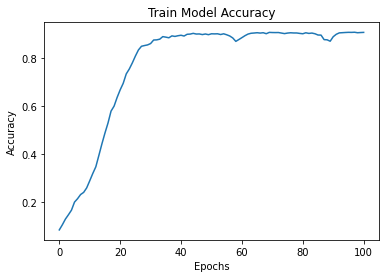

In [66]:
plt.plot(history['accuracy'])
plt.title('Train Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.show()

# Plot Accuracy vs Loss

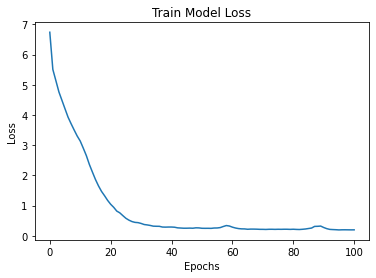

In [67]:
plt.plot(history['loss'])
plt.title('Train Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.show()

# Generate Captions for the Image

In [68]:
def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None
def extract_features(filename, model):
        try:
            image = Image.open(filename)           
        except:
            print("ERROR: Couldn't open image! Make sure the image path and extension is correct")
        image = image.resize((299,299))
        image = np.array(image)
        # for images that has 4 channels, we convert them into 3 channels
        if image.shape[2] == 4: 
            image = image[..., :3]
        image = np.expand_dims(image, axis=0)
        image = image/255
        feature = model.predict(image)
        return feature
def generate_desc(model, tokenizer, photo, max_length):
    in_text = 'start'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        pred = model.predict([photo,sequence], verbose=0, batch_size = 64)
        pred = np.argmax(pred)
        word = word_for_id(pred, tokenizer)
        if word is None:
            break
        in_text += ' ' + word
        if word == 'end':
            break
    return in_text[6:-3]

# Display Caption

In [71]:
max_length = 31
tokenizer = load(open(os.path.join(save_data,"tokenizer.p"),"rb"))
model = load_model("model\\models\\model100.h5")
xception_model = Xception(include_top=False, pooling="avg")



aeroplane ready for the takeoff 


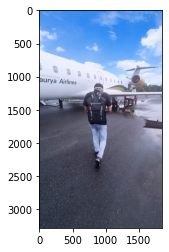

In [73]:
img_path = os.path.join(dataset_images,'Bibek2.jpg')
#img_path = "C:\\Users\\shlok\\Downloads\\9.jpg"

photo = extract_features(img_path, xception_model)
img = Image.open(img_path)
description = generate_desc(model, tokenizer, photo, max_length)
print("\n")
print(description)
plt.imshow(img)

# Calculate BLEU Score

In [74]:
# from nltk.translate.bleu_score import corpus_bleu
# # validate with test data
# actual, predicted = list(), list()

# for key in tqdm(test):
#     # get actual caption
#     captions = descriptions[key]
#     # predict the caption for image
#     y_pred = generate_desc(model, tokenizer, features[key], max_length) 
#     # split into words
#     actual_captions = [caption.split() for caption in captions]
#     y_pred = y_pred.split()
#     # append to the list
#     actual.append(actual_captions)
#     predicted.append(y_pred)

In [75]:
# calcuate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

BLEU-1: 0.328211
BLEU-2: 0.155498
